import necessary modules

In [1]:
import numpy as np
import pandas as pd
import duckdb
import os
import glob
import matplotlib.pyplot as plt

Create in memory view tables for each csv file, only ignoring transactions data for now.

In [ ]:
import duckdb 

# Connect to DuckDB
con = duckdb.connect(database=':memory:')


data_folder = '../data/'
csv_files = glob.glob(os.path.join(data_folder, '*.csv*'))

# Filter out transactions file
csv_files = [f for f in csv_files if 'transactions' not in os.path.basename(f).lower()]

print(f"Creating views for {len(csv_files)} files:")

# Create views for each file
for file_path in csv_files:
    
    file_name = os.path.basename(file_path)
    file_name = file_name.replace('.csv.gz', '').replace('.csv', '')    
    is_gzipped = file_path.endswith('.gz')
    
    # Create view
    query = f"""
    CREATE OR REPLACE VIEW {file_name} AS
    SELECT * FROM read_csv('{file_path}', header=True, 
                          compression='gzip' WHERE compression='auto')
    """
    
    # Execute query with proper compression parameter
    if is_gzipped:
        query = f"""
        CREATE OR REPLACE VIEW {file_name} AS
        SELECT * FROM read_csv('{file_path}', header=True, compression='gzip')
        """
    else:
        query = f"""
        CREATE OR REPLACE VIEW {file_name} AS
        SELECT * FROM read_csv('{file_path}', header=True)
        """
    
    con.execute(query)
    print(f"✅ Created view for {file_name}")
    
    # Show row count
    count = con.execute(f"SELECT COUNT(*) FROM {file_name}").fetchone()[0]
    print(f"   - {count:,} rows")
    
    # Show first 3 rows
    first_rows = con.execute(f"SELECT * FROM {file_name} LIMIT 3").fetchdf()
    display(first_rows)
    
    print("-" * 60)

print("\n🎉 All views created successfully!")

# List all views
views = con.execute("SHOW TABLES").fetchdf()
print("\n📊 Available views:")
display(views)

Creating views for 4 files:
✅ Created view for offers
   - 37 rows


,offer,category,quantity,company,offervalue,brand
0,1190530,9115,1,108500080,5.00,93904
1,1194044,9909,1,107127979,1.00,6732
2,1197502,3203,1,106414464,0.75,13474


------------------------------------------------------------
✅ Created view for sampleSubmission
   - 151,484 rows


,id,repeatProbability
0,12262064,0
1,12277270,0
2,12332190,0


------------------------------------------------------------
✅ Created view for testHistory
   - 151,484 rows


,id,chain,offer,market,offerdate
0,12262064,95,1219903,39,2013-06-27
1,12277270,95,1221658,39,2013-06-23
2,12332190,95,1213242,39,2013-06-15


------------------------------------------------------------
✅ Created view for trainHistory
   - 160,057 rows


,id,chain,offer,market,repeattrips,repeater,offerdate
0,86246,205,1208251,34,5,True,2013-04-24
1,86252,205,1197502,34,16,True,2013-03-27
2,12682470,18,1197502,11,0,False,2013-03-28


------------------------------------------------------------

🎉 All views created successfully!

📊 Available views:


,name
0,offers
1,sampleSubmission
2,testHistory
3,trainHistory


In [18]:
q = """
select 
    'train' as dataset,
    min(offerdate) as min_offerdate,
    max(offerdate) as max_offerdate,    
    count(distinct id) as unique_ids,
    count(*) as total_rows,
    countif(id is null) as null_ids,
    countif(offerdate is null) as null_offerdate,
    countif(chain is null) as null_chain,
    countif(market is null) as null_market,
from trainHistory as t1

union all 

select
    'test' as dataset,
    min(offerdate) as min_offerdate,
    max(offerdate) as max_offerdate,
    count(distinct id)  as unique_ids,
    count(*) as total_rows,
    countif(id is null) as null_ids,
    countif(offerdate is null) as null_offerdate,
    countif(chain is null) as null_chain,
    countif(market is null) as null_market,
from testHistory as t2
"""

summary = con.execute(q).fetchdf()
print("\n📊 Summary of trainHistory and testHistory:")
display(summary)


📊 Summary of trainHistory and testHistory:


,dataset,min_offerdate,max_offerdate,unique_ids,total_rows,null_ids,null_offerdate,null_chain,null_market
0,train,2013-03-01,2013-04-30,160057,160057,0.0,0.0,0.0,0.0
1,test,2013-05-01,2013-07-31,151484,151484,0.0,0.0,0.0,0.0


Now, let us inspect transactions further since it is much larger than other files.

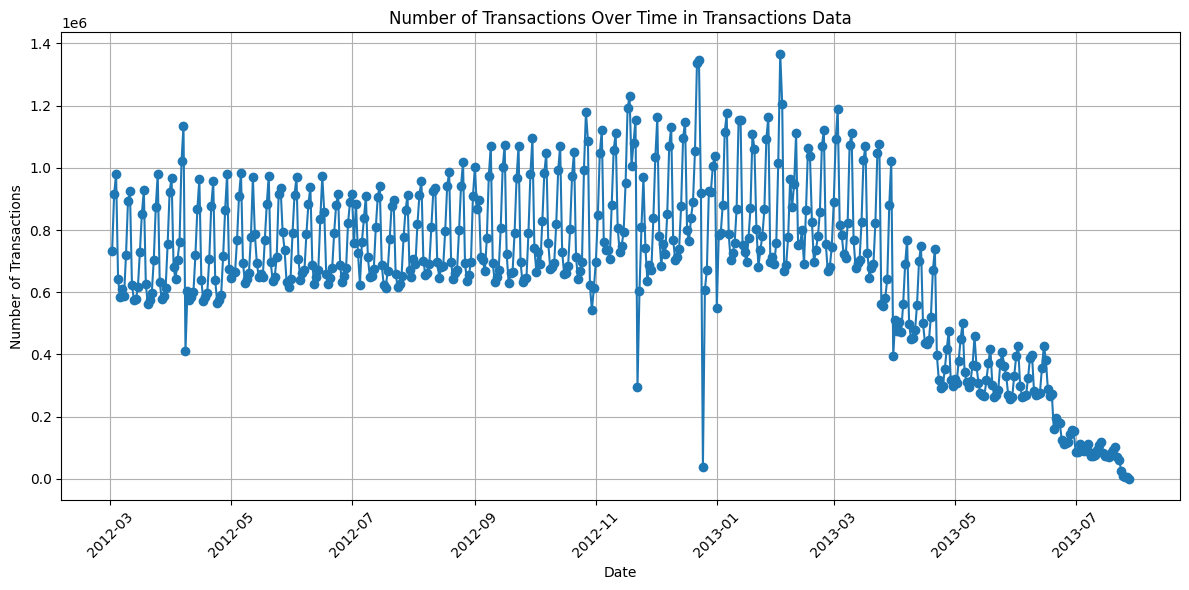

In [11]:
q = """
select
    date,
    count(*) as num_transactions,
from read_csv('../data/transactions.csv.gz', header=True, compression='gzip')
group by 1
order by 1
""" 
summary_trx = con.execute(q).fetchdf()


## print a plot date against num_transactions
plt.figure(figsize=(12,6))
plt.plot(summary_trx['date'], summary_trx['num_transactions'], marker='o')
plt.title('Number of Transactions Over Time in Transactions Data')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()



In [19]:
q = """
select
    *
from read_csv('../data/transactions.csv.gz', header=True, compression='gzip')
where id = 604159127
""" 
summary_trx = con.execute(q).fetchdf()

In [27]:
summary_trx.loc[summary_trx.company == 103320030, :]

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount


In [28]:
q = """
select 
    count(distinct company) as n_companies,
    count(distinct offer) as n_offers,
    count(distinct category) as n_categories,
    count(distinct brand) as n_brands
from offers
"""
con.execute(q).fetchdf()

,n_companies,n_offers,n_categories,n_brands
0,18,37,20,19


In [35]:

query = """
create or replace temp table transactions_sample as 
select *
from read_csv('../data/transactions.csv.gz', header=True, compression='gzip') 
order by random()
limit 100000
"""
con.execute(query)

trx_df = con.execute("select * from transactions_sample").fetchdf()
trx_df.head()

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,3415432618,64,58,5824,107778272,9260,2012-04-10,14.00,OZ,1,1.10
1,565648811,21,17,1703,103500030,6073,2012-07-06,28.00,OZ,1,1.99
2,3957949189,48,9,916,1089477181,23207,2013-04-19,4.50,OZ,1,4.99
3,1815066997,143,51,5125,101380010,10271,2012-06-20,10.50,OZ,2,3.58
4,4425272519,187,14,1414,102400020,4704,2013-03-19,8.25,OZ,2,2.00


In [33]:
q = """
select
    count(distinct id) as customer_count,
    count(distinct chain) as company_count,
    count(distinct dept) as department_count,
    count(distinct category) as category_count,
    count(distinct brand) as brand_count,
    min(date) as sample_start_date,
    max(date) as sample_end_date,
    count(distinct date) as n_days
from read_csv('../data/transactions.csv.gz', header=True, compression='gzip')
""" 
summary_trx = con.execute(q).fetchdf()
summary_trx 


,customer_count,company_count,department_count,category_count,brand_count,sample_start_date,sample_end_date,n_days
0,311541,134,83,836,35689,2012-03-02,2013-07-28,514
